In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# 确保 PyTorch 使用 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# --- 特征工程函数 (from Cell 3) ---
# 为防止RSI计算中除以零，添加了一个小的 epsilon
def compute_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    RS = gain / (loss + 1e-10)  # 添加 epsilon 防止除以零
    return 100 - (100 / (1 + RS))

def feature_engineering(df):
    """根据 'Close' 列计算所有技术指标"""
    df_feat = df[['Open Time', 'Close']].copy()
    df_feat['Return'] = df_feat['Close'].pct_change()
    
    # MA 均线
    df_feat['MA5'] = df_feat['Close'].rolling(window=5).mean()
    df_feat['MA10'] = df_feat['Close'].rolling(window=10).mean()
    df_feat['MA20'] = df_feat['Close'].rolling(window=20).mean()
    
    # RSI
    df_feat['RSI14'] = compute_RSI(df_feat['Close'], 14)
    
    # MACD
    ema12 = df_feat['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df_feat['Close'].ewm(span=26, adjust=False).mean()
    df_feat['MACD'] = ema12 - ema26
    df_feat['Signal'] = df_feat['MACD'].ewm(span=9, adjust=False).mean()
    df_feat['MACD_Hist'] = df_feat['MACD'] - df_feat['Signal']
    
    # Bollinger Bands
    window_bb = 20
    std = df_feat['Close'].rolling(window_bb).std()
    df_feat['BB_Mid'] = df_feat['Close'].rolling(window_bb).mean()
    df_feat['BB_Upper'] = df_feat['BB_Mid'] + 2 * std
    df_feat['BB_Lower'] = df_feat['BB_Mid'] - 2 * std
    
    # 删除指标计算产生的 NaN
    df_feat = df_feat.dropna().reset_index(drop=True)
    return df_feat

# --- 滑动窗口函数 (from Cell 5) ---
def create_dataset(dataset, window=5):
    X, y = [], []
    for i in range(len(dataset) - window):
        X.append(dataset[i:i+window, :])  # 所有特征
        y.append(dataset[i+window, 0])    # 仅预测 Close
    return np.array(X), np.array(y)

# --- LSTM 模型定义 (from Cell 6) ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            batch_first=True, 
                            dropout=dropout, 
                            num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# --- 权重初始化 (from Cell 6) ---
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [3]:
# --- 1. 路径配置 ---
# 请确保使用正斜杠 / 或者双反斜杠 \\
INPUT_DIR = "F:/Learning_journal_at_CUHK/FTEC5520_Appl Blockchain & Cryptocur/Simulation/data/coin/USD"
OUTPUT_DIR = "F:/Learning_journal_at_CUHK/FTEC5520_Appl Blockchain & Cryptocur/Simulation/data/prediction/USD"

# 确保输出目录存在
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- 2. 币种列表 ---
COIN_FILES = [
    "AAVE_hourly_price_data.csv",
    "cbBTC_hourly_price_data.csv",
    "cbETH_hourly_price_data.csv",
    "EURC_hourly_price_data.csv",
    "weETH_hourly_price_data.csv"
]

# --- 3. 预测日期范围 (您指定的范围) ---
PREDICTION_START_DATE = "2025-10-21T17:00:00+00:00"
PREDICTION_END_DATE = "2025-10-30T12:00:00+00:00"

# --- 4. 特征列表 (from Cell 4) ---
FEATURES_LIST = [
    'Close', 'Return', 'MA5', 'MA10', 'MA20',
    'RSI14', 'MACD', 'Signal', 'MACD_Hist',
    'BB_Mid', 'BB_Upper', 'BB_Lower'
]
INPUT_SIZE = len(FEATURES_LIST)

# --- 5. 超参数调优 ---
# 为每个币种定义不同的参数
hyperparameters = {
    "default": {
        "hidden_size": 64, "num_layers": 2, "dropout": 0.2,
        "epochs": 60, "lr": 1e-3, "window": 5, "batch_size": 32
    },
    "AAVE": {
        "hidden_size": 64, "num_layers": 2, "dropout": 0.2,
        "epochs": 60, "lr": 1e-3, "window": 5, "batch_size": 32
    },
    "cbBTC": {
        "hidden_size": 128, "num_layers": 2, "dropout": 0.2,
        "epochs": 70, "lr": 1e-3, "window": 10, "batch_size": 32
    },
    "cbETH": {
        "hidden_size": 64, "num_layers": 2, "dropout": 0.2,
        "epochs": 60, "lr": 1e-3, "window": 5, "batch_size": 32
    },
    "EURC": { # 稳定币，使用更简单的模型
        "hidden_size": 32, "num_layers": 1, "dropout": 0.1,
        "epochs": 40, "lr": 5e-4, "window": 3, "batch_size": 16
    },
    "weETH": { # 原始设置
        "hidden_size": 64, "num_layers": 2, "dropout": 0.2,
        "epochs": 60, "lr": 1e-3, "window": 5, "batch_size": 32
    }
}

print("配置加载完毕。")

配置加载完毕。


In [8]:
for coin_file in COIN_FILES:
    coin_name = coin_file.split('_')[0]
    print(f"\n{'='*50}\nProcessing: {coin_name}\n{'='*50}")

    # --- 1. 加载参数 ---
    params = hyperparameters.get(coin_name, hyperparameters['default'])
    window = params['window']
    
    # --- 2. 加载与特征工程 ---
    try:
        file_path = os.path.join(INPUT_DIR, coin_file)
        data_df_raw = pd.read_csv(file_path)
        data_df_raw = data_df_raw.rename(columns={'datetime_utc': 'Open Time', 'price_usd': 'Close'})
        
        # --- (!!!) 修正点 1: 处理日期、取整、去重 ---
        # 1. 使用 format='ISO8601' 处理混合格式
        data_df_raw['Open Time'] = pd.to_datetime(data_df_raw['Open Time'], format='ISO8601')
        
        # 2. (新需求) 向下取整到小时
        data_df_raw['Open Time'] = data_df_raw['Open Time'].dt.floor('h')
        
        # 3. (新需求) 去除同一小时内的重复数据, 保留该小时的最后一条记录
        data_df_raw = data_df_raw.drop_duplicates(subset='Open Time', keep='last')
        
        # 4. 排序
        data_df_raw = data_df_raw.sort_values('Open Time')
        # --- 修正结束 ---
        
        # 应用特征工程
        data_df_feat = feature_engineering(data_df_raw)
        
        if data_df_feat.empty or len(data_df_feat) < window + 1:
            print(f"  [Warning] No data remaining for {coin_name} after feature engineering/aggregation. Skipping.")
            continue
            
        feature_data = data_df_feat[FEATURES_LIST].values
        print(f"  Data loaded, aggregated to hour, and features engineered. Total rows: {len(feature_data)}")

    except Exception as e:
        print(f"  [Error] Failed to load or process data for {coin_name}: {e}")
        continue

    # --- 3. 预处理 ---
    train_size = int(len(feature_data) * 0.7)
    train_data, test_data = feature_data[:train_size], feature_data[train_size:]
    
    # 确保测试集至少有一个窗口+一个标签
    if len(test_data) < window + 1:
        print(f"  [Warning] Test data for {coin_name} is too small (< {window+1} rows) after split. Skipping.")
        continue

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    X_train, y_train = create_dataset(train_scaled, window)
    X_test, y_test = create_dataset(test_scaled, window)
    
    # 确保 X_test 不是空的
    if len(X_test) == 0:
        print(f"  [Warning] No test samples created for {coin_name} (window={window}). Skipping.")
        continue

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
    y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train, y_train),
                              batch_size=params['batch_size'], 
                              shuffle=True)
    
    print(f"  Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    # --- 4. 模型初始化 ---
    model = LSTMModel(
        input_size=INPUT_SIZE,
        hidden_size=params['hidden_size'],
        num_layers=params['num_layers'],
        dropout=params['dropout']
    ).to(device)
    
    model.apply(init_weights)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)

    # --- 5. 训练 ---
    print(f"  Starting training for {params['epochs']} epochs...")
    epochs = params['epochs']
    for epoch in range(epochs):
        model.train()
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            
            optimizer.zero_grad()
            output = model(Xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
        
        scheduler.step()
        
        # 每 20% 打印一次进度
        if epochs > 0 and ((epoch + 1) % max(1, (epochs // 5)) == 0 or epoch == epochs - 1):
            print(f"    Epoch {epoch+1}/{epochs}, Loss = {loss.item():.6f}, LR={scheduler.get_last_lr()[0]:.6f}")

    # --- 6. 预测与反归一化 ---
    print("  Training complete. Starting prediction...")
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test.to(device)).cpu().numpy()

    dummy_true = np.zeros((len(y_test), INPUT_SIZE))
    dummy_pred = np.zeros((len(y_pred_scaled), INPUT_SIZE))

    dummy_true[:, 0] = y_test.numpy().flatten()
    dummy_pred[:, 0] = y_pred_scaled.flatten()

    y_true_actual = scaler.inverse_transform(dummy_true)[:, 0]
    y_pred_actual = scaler.inverse_transform(dummy_pred)[:, 0]

    # --- 7. 评估 (Metrics) ---
    rmse = np.sqrt(mean_squared_error(y_true_actual, y_pred_actual))
    mae = mean_absolute_error(y_true_actual, y_pred_actual)
    r2 = r2_score(y_true_actual, y_pred_actual)
    
    print(f"  Prediction Metrics ({coin_name}):")
    print(f"    RMSE: {rmse:.4f}")
    print(f"    MAE:  {mae:.4f}")
    print(f"    R²:   {r2:.4f}")

    # --- 8. 过滤并保存结果 ---
    test_dates_start_index = train_size + window
    
    # 使用 .values 会丢失时区信息, 导致后续比较出错
    test_dates_naive = data_df_feat['Open Time'].iloc[test_dates_start_index:].values

    results_df = pd.DataFrame({
        'Open Time': test_dates_naive,
        'Actual_Price': y_true_actual.flatten(),
        'Predicted_Price': y_pred_actual.flatten()
    })

    # --- (!!!) 修正点 2: 解决时区比较错误 ---
    # 1. 将结果中的 'Open Time' (现在是 naive) 重新设置为 UTC 时区
    results_df['Open Time'] = pd.to_datetime(results_df['Open Time']).dt.tz_localize('UTC')

    # 2. 将筛选日期也设置为带时区的 (它们已经是 +00:00, 即 UTC)
    start_dt = pd.to_datetime(PREDICTION_START_DATE)
    end_dt = pd.to_datetime(PREDICTION_END_DATE)
    # --- 修正结束 ---

    # 筛选 (现在是 'aware' vs 'aware' 比较)
    filtered_results_df = results_df[
        (results_df['Open Time'] >= start_dt) & 
        (results_df['Open Time'] <= end_dt)
    ].copy()

    # 保存到 CSV
    output_filename = os.path.join(OUTPUT_DIR, f"{coin_name}_prediction_output.csv")
    filtered_results_df.to_csv(output_filename, index=False)
    
    print(f"  Successfully saved {len(filtered_results_df)} predictions to {output_filename}")

print(f"\n{'='*50}\nAll processing complete.\n{'='*50}")


Processing: AAVE
  Data loaded, aggregated to hour, and features engineered. Total rows: 2141
  Train shape: torch.Size([1493, 5, 12]), Test shape: torch.Size([638, 5, 12])
  Starting training for 60 epochs...
    Epoch 12/60, Loss = 0.001376, LR=0.001000
    Epoch 24/60, Loss = 0.000553, LR=0.001000
    Epoch 36/60, Loss = 0.000379, LR=0.000700
    Epoch 48/60, Loss = 0.000184, LR=0.000700
    Epoch 60/60, Loss = 0.000224, LR=0.000490
  Training complete. Starting prediction...
  Prediction Metrics (AAVE):
    RMSE: 5.2762
    MAE:  4.1448
    R²:   0.9582
  Successfully saved 212 predictions to F:/Learning_journal_at_CUHK/FTEC5520_Appl Blockchain & Cryptocur/Simulation/data/prediction/USD\AAVE_prediction_output.csv

Processing: cbBTC
  Data loaded, aggregated to hour, and features engineered. Total rows: 2141
  Train shape: torch.Size([1488, 10, 12]), Test shape: torch.Size([633, 10, 12])
  Starting training for 70 epochs...
    Epoch 14/70, Loss = 0.000827, LR=0.001000
    Epoch 28

c:\Users\10158\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


    Epoch 8/40, Loss = 0.000562, LR=0.000500
    Epoch 16/40, Loss = 0.000703, LR=0.000500
    Epoch 24/40, Loss = 0.001321, LR=0.000500
    Epoch 32/40, Loss = 0.000506, LR=0.000350
    Epoch 40/40, Loss = 0.000775, LR=0.000350
  Training complete. Starting prediction...
  Prediction Metrics (EURC):
    RMSE: 0.0012
    MAE:  0.0008
    R²:   0.9694
  Successfully saved 212 predictions to F:/Learning_journal_at_CUHK/FTEC5520_Appl Blockchain & Cryptocur/Simulation/data/prediction/USD\EURC_prediction_output.csv

Processing: weETH
  Data loaded, aggregated to hour, and features engineered. Total rows: 2141
  Train shape: torch.Size([1493, 5, 12]), Test shape: torch.Size([638, 5, 12])
  Starting training for 60 epochs...
    Epoch 12/60, Loss = 0.000553, LR=0.001000
    Epoch 24/60, Loss = 0.000741, LR=0.001000
    Epoch 36/60, Loss = 0.000509, LR=0.000700
    Epoch 48/60, Loss = 0.000464, LR=0.000700
    Epoch 60/60, Loss = 0.000304, LR=0.000490
  Training complete. Starting prediction..

# 作图对比真实值和预测值

Plotting results for the period: 2025-10-21T17:00:00+00:00 to 2025-10-30T12:00:00+00:00



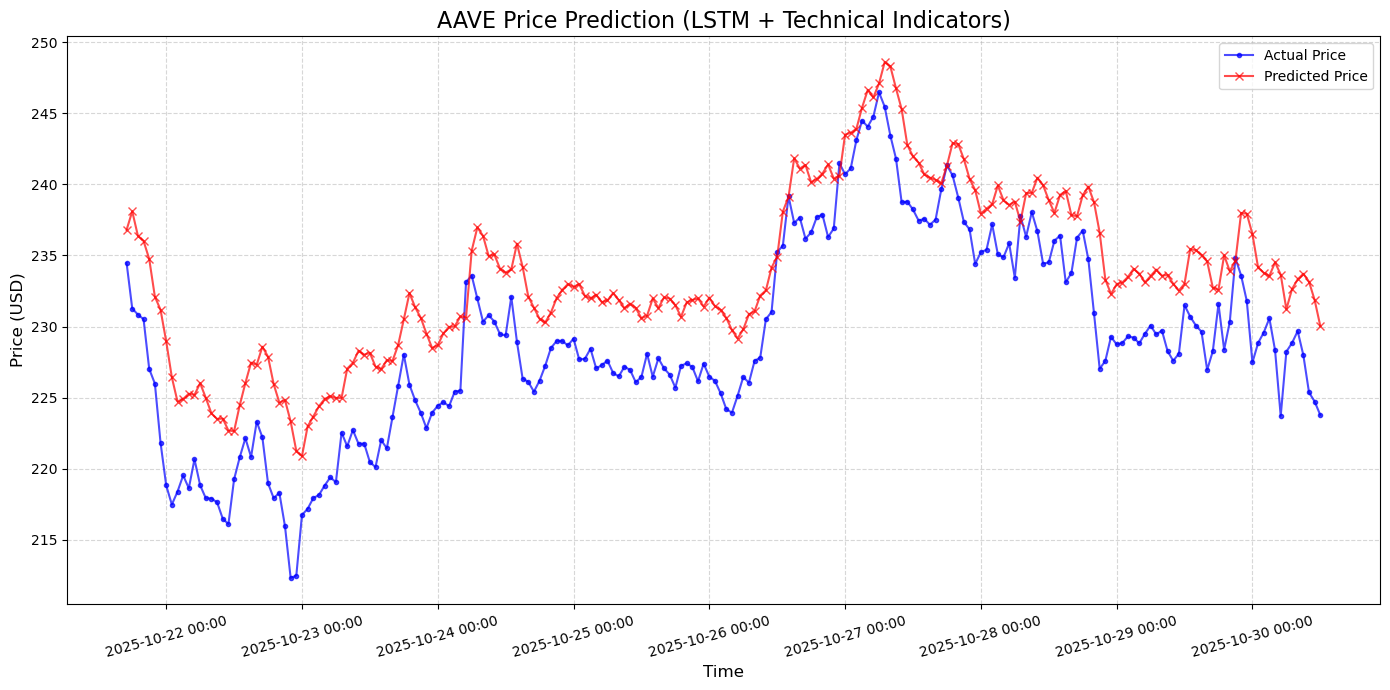

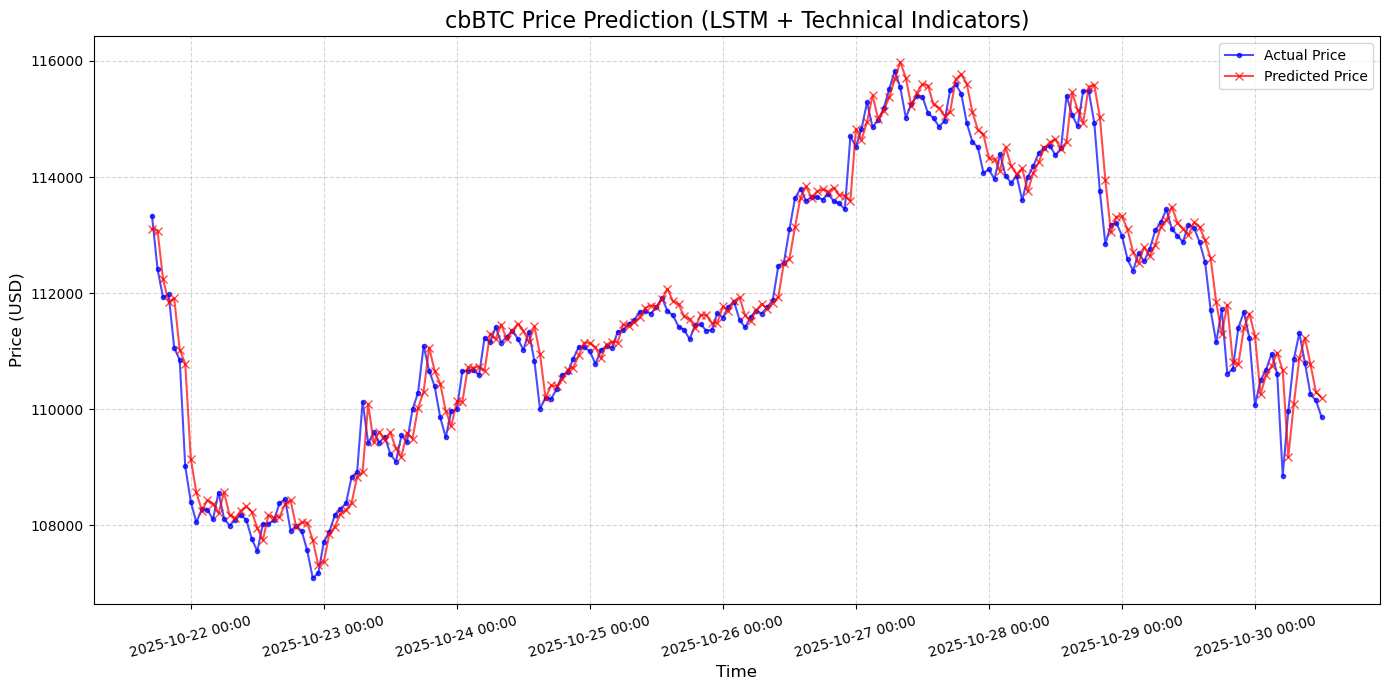

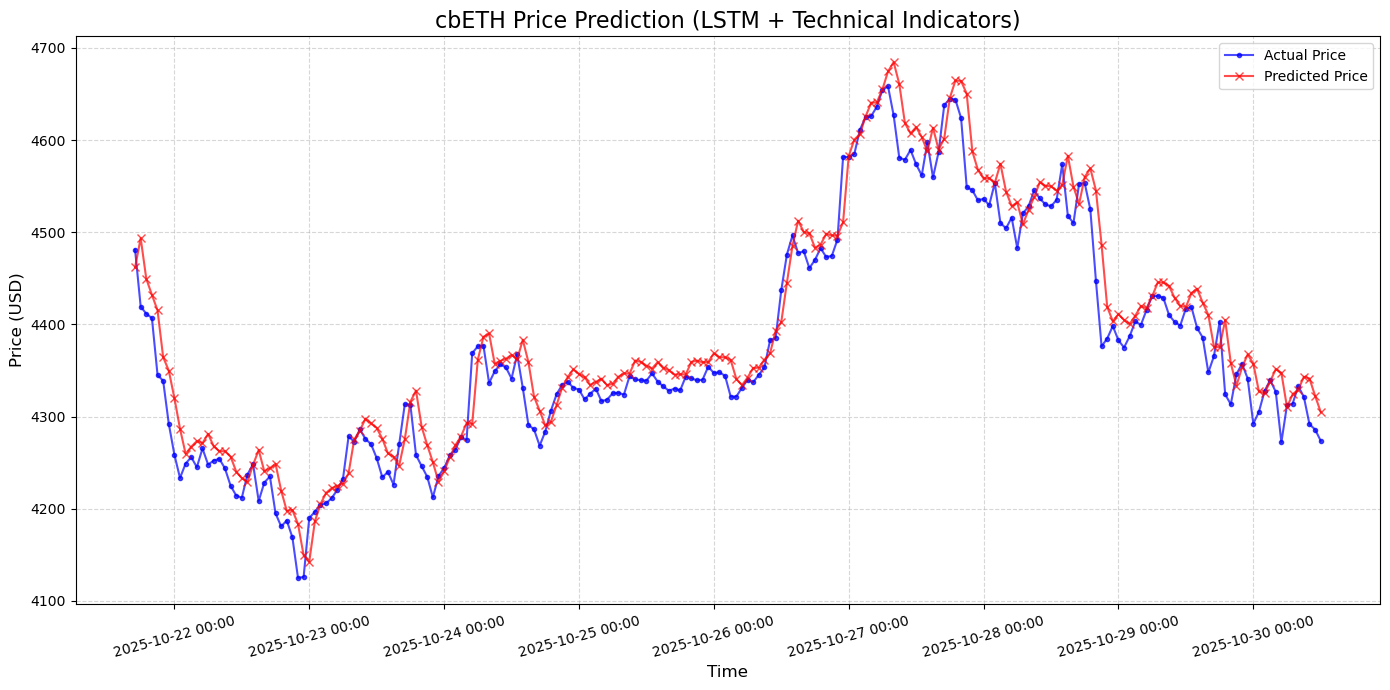

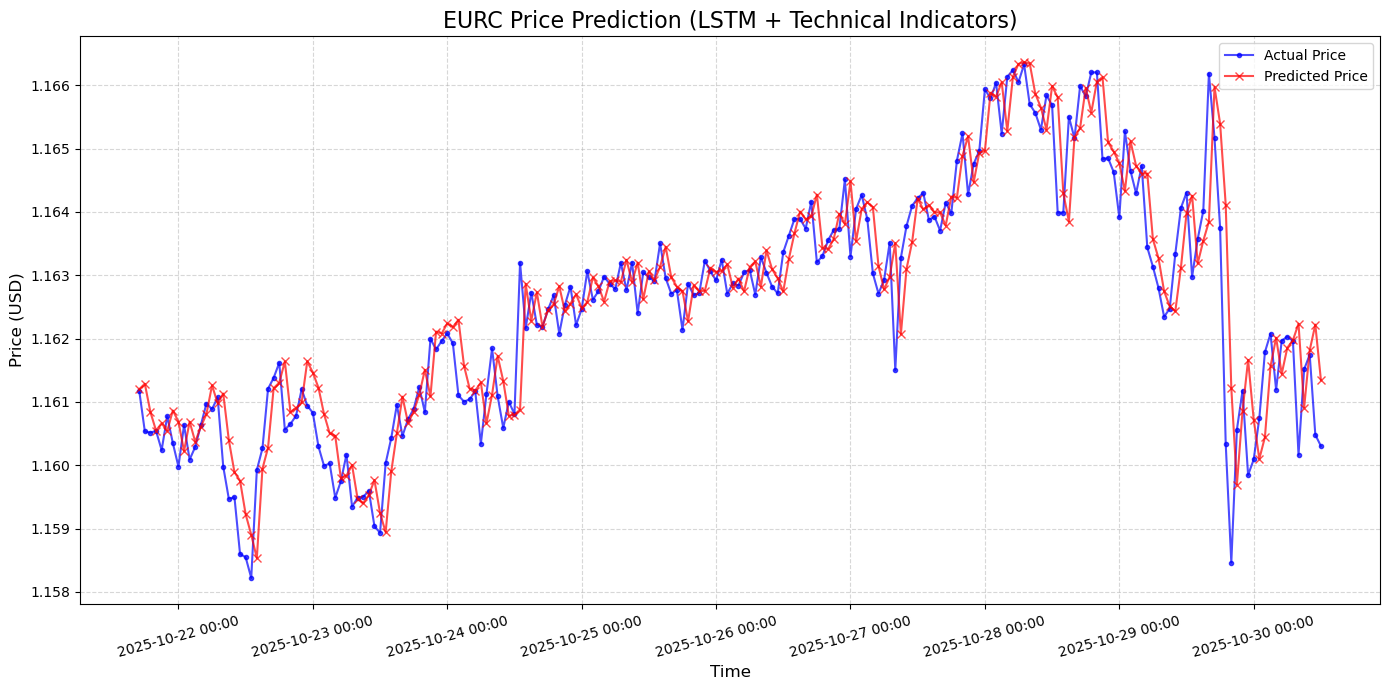

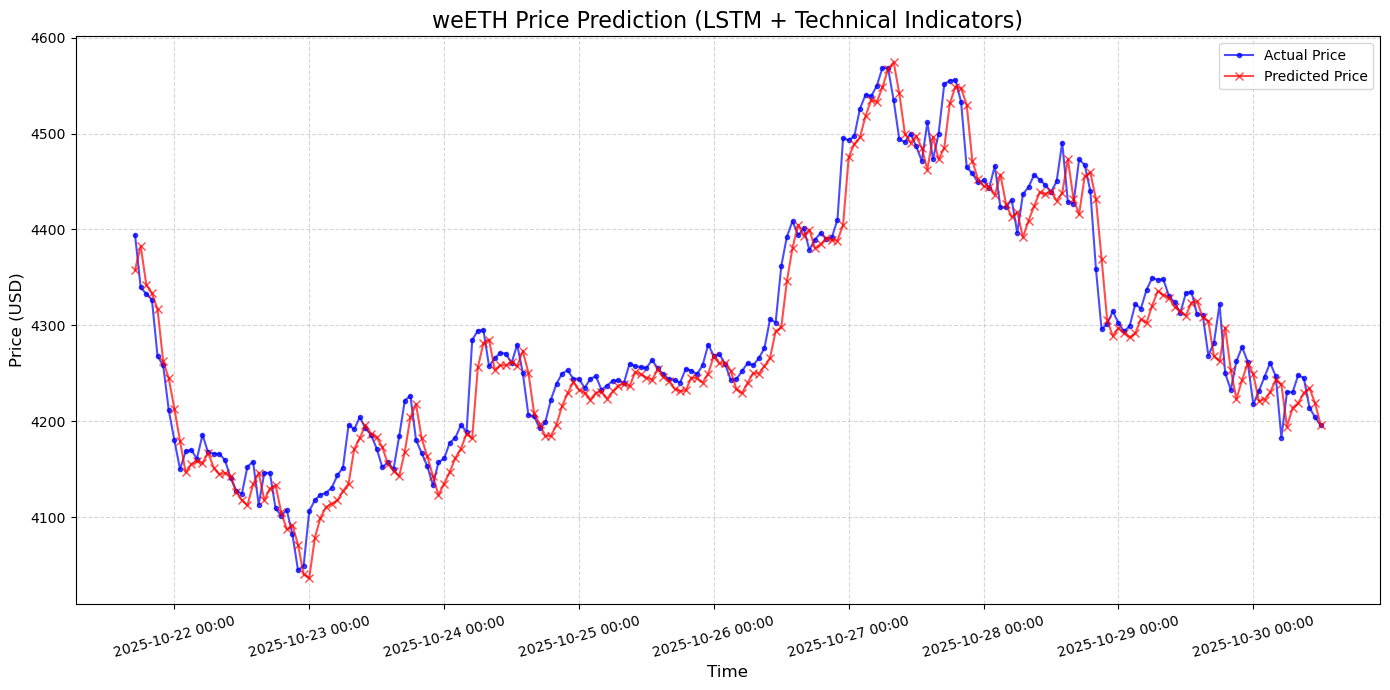


All plotting complete.


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.dates as mdates

# --- 配置 (从单元 3 复制) ---
# 请确保这些变量与您在 单元 3 中定义的变量一致
OUTPUT_DIR = "F:/Learning_journal_at_CUHK/FTEC5520_Appl Blockchain & Cryptocur/Simulation/data/prediction/USD"
COIN_FILES = [
    "AAVE_hourly_price_data.csv",
    "cbBTC_hourly_price_data.csv",
    "cbETH_hourly_price_data.csv",
    "EURC_hourly_price_data.csv",
    "weETH_hourly_price_data.csv"
]
PREDICTION_START_DATE = "2025-10-21T17:00:00+00:00"
PREDICTION_END_DATE = "2025-10-30T12:00:00+00:00"
# --- 配置结束 ---


print(f"Plotting results for the period: {PREDICTION_START_DATE} to {PREDICTION_END_DATE}\n")

for coin_file in COIN_FILES:
    coin_name = coin_file.split('_')[0]
    prediction_filename = os.path.join(OUTPUT_DIR, f"{coin_name}_prediction_output.csv")
    
    # 检查预测文件是否存在
    if not os.path.exists(prediction_filename):
        print(f"--- Skipping {coin_name}: Prediction file not found (likely skipped during training). ---")
        continue

    # 读取已保存的预测数据
    try:
        plot_df = pd.read_csv(prediction_filename)
        
        if plot_df.empty:
            print(f"--- Skipping {coin_name}: No prediction data found in the specified date range. ---")
            continue
            
        # 转换 Open Time 为 datetime 对象以便绘图
        plot_df['Open Time'] = pd.to_datetime(plot_df['Open Time'])

        # --- 绘图 ---
        plt.figure(figsize=(14, 7))
        plt.plot(plot_df['Open Time'], plot_df['Actual_Price'], label='Actual Price', color='blue', marker='.', alpha=0.7)
        plt.plot(plot_df['Open Time'], plot_df['Predicted_Price'], label='Predicted Price', color='red', marker='x', alpha=0.7)
        
        plt.title(f"{coin_name} Price Prediction (LSTM + Technical Indicators)", fontsize=16)
        plt.xlabel("Time", fontsize=12)
        plt.ylabel("Price (USD)", fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        
        # 格式化X轴日期显示
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.xticks(rotation=15)
        
        plt.tight_layout()
        plt.show() # 显示图形
        
    except Exception as e:
        print(f"--- Error plotting {coin_name}: {e} ---")

print("\nAll plotting complete.")

# 转换为ETH标度

In [10]:
import pandas as pd
import os

# --- 1. 定义路径 (请确保与您之前的单元格一致) ---
PREDICTION_USD_DIR = "F:/Learning_journal_at_CUHK/FTEC5520_Appl Blockchain & Cryptocur/Simulation/data/prediction/USD"
COIN_FILES_BASE = [
    "AAVE_hourly_price_data.csv",
    "cbBTC_hourly_price_data.csv",
    "cbETH_hourly_price_data.csv",
    "EURC_hourly_price_data.csv",
    "weETH_hourly_price_data.csv"
]
# 新的 ETH 价格文件路径和输出路径
ETH_PRICE_FILE_PATH = "F:/Learning_journal_at_CUHK/FTEC5520_Appl Blockchain & Cryptocur/Simulation/data/coin/USD/---ETH_hourly_price_data.csv"
OUTPUT_DIR_ETH = "F:/Learning_journal_at_CUHK/FTEC5520_Appl Blockchain & Cryptocur/Simulation/data/prediction/swap_to_ETH"

# 确保输出目录存在
os.makedirs(OUTPUT_DIR_ETH, exist_ok=True)


# --- 2. 加载并处理 ETH 价格数据 ---
print(f"Loading ETH price data from: {ETH_PRICE_FILE_PATH}")
try:
    eth_price_df = pd.read_csv(ETH_PRICE_FILE_PATH)
    
    # 假设列名为 'datetime_utc' 和 'price_usd' (与您其他文件一致)
    # 如果列名是 'price'，read_csv 后的 rename 会失败，请在下方修改
    if 'price' in eth_price_df.columns and 'price_usd' not in eth_price_df.columns:
         eth_price_df = eth_price_df.rename(columns={'price': 'price_usd'})
         
    eth_price_df = eth_price_df.rename(columns={'datetime_utc': 'Open Time', 'price_usd': 'ETH_Price_USD'})
    
    # 执行与训练数据完全一致的日期处理
    eth_price_df['Open Time'] = pd.to_datetime(eth_price_df['Open Time'], format='ISO8601')
    eth_price_df['Open Time'] = eth_price_df['Open Time'].dt.floor('h')
    eth_price_df = eth_price_df.drop_duplicates(subset='Open Time', keep='last')
    
    # 关键：设置为带时区的索引，以便合并
    if eth_price_df['Open Time'].dt.tz is None:
        eth_price_df['Open Time'] = eth_price_df['Open Time'].dt.tz_localize('UTC')
    else:
        eth_price_df['Open Time'] = eth_price_df['Open Time'].dt.tz_convert('UTC')
        
    eth_price_df = eth_price_df.set_index('Open Time')
    
    print(f"Successfully loaded and processed ETH price data. {len(eth_price_df)} hourly records found.")

except Exception as e:
    print(f"[CRITICAL ERROR] Could not load or process ETH price file: {e}")
    print("Aborting conversion.")
    eth_price_df = None # 设为 None 以跳过后续循环

# --- 3. 循环转换每个币种的预测文件 ---
if eth_price_df is not None:
    
    for coin_file in COIN_FILES_BASE:
        coin_name = coin_file.split('_')[0]
        prediction_usd_filename = os.path.join(PREDICTION_USD_DIR, f"{coin_name}_prediction_output.csv")
        
        print(f"\n--- Converting {coin_name} predictions to ETH scale ---")

        if not os.path.exists(prediction_usd_filename):
            print(f"  [Warning] Skipping {coin_name}: File {prediction_usd_filename} not found.")
            continue
            
        try:
            # 加载已保存的 USD 预测结果
            pred_df = pd.read_csv(prediction_usd_filename)
            
            if pred_df.empty:
                print(f"  [Warning] Skipping {coin_name}: USD Prediction file is empty.")
                continue
            
            # 关键：将 'Open Time' 转换为带 UTC 时区的索引，以便与 ETH 价格合并
            pred_df['Open Time'] = pd.to_datetime(pred_df['Open Time'])
            if pred_df['Open Time'].dt.tz is None:
                pred_df['Open Time'] = pred_df['Open Time'].dt.tz_localize('UTC')
            else:
                pred_df['Open Time'] = pred_df['Open Time'].dt.tz_convert('UTC')
            
            pred_df = pred_df.set_index('Open Time')
            
            # --- 合并数据 ---
            # 使用左连接 (left join) 将 ETH 价格合并到预测数据上
            merged_df = pred_df.join(eth_price_df, how='left')

            # --- 计算 ETH 标度价格 ---
            merged_df['Actual_Price_ETH'] = merged_df['Actual_Price'] / merged_df['ETH_Price_USD']
            merged_df['Predicted_Price_ETH'] = merged_df['Predicted_Price'] / merged_df['ETH_Price_USD']
            
            # 重命名 USD 列以便区分
            merged_df = merged_df.rename(columns={
                'Actual_Price': 'Actual_Price_USD',
                'Predicted_Price': 'Predicted_Price_USD'
            })
            
            # --- 整理并保存 ---
            # 选择我们需要的列
            output_df = merged_df[[
                'Actual_Price_USD', 'Predicted_Price_USD', 
                'ETH_Price_USD', 
                'Actual_Price_ETH', 'Predicted_Price_ETH'
            ]]
            
            # 移除 ETH 价格缺失导致计算失败的行
            output_df = output_df.dropna(subset=['Actual_Price_ETH', 'Predicted_Price_ETH'])
            
            if output_df.empty:
                print(f"  [Warning] Skipping {coin_name}: No matching ETH price data found for the predicted timestamps.")
                continue

            # 保存到新目录
            output_filename = os.path.join(OUTPUT_DIR_ETH, f"{coin_name}_prediction_ETH.csv")
            output_df.to_csv(output_filename, index=True) # index=True 保留 Open Time 索引
            
            print(f"  Successfully saved {len(output_df)} ETH-denominated predictions to {output_filename}")

        except Exception as e:
            print(f"  [Error] Failed to convert {coin_name}: {e}")

print(f"\n{'='*50}\nETH conversion process complete.\n{'='*50}")

Loading ETH price data from: F:/Learning_journal_at_CUHK/FTEC5520_Appl Blockchain & Cryptocur/Simulation/data/coin/USD/---ETH_hourly_price_data.csv
Successfully loaded and processed ETH price data. 2160 hourly records found.

--- Converting AAVE predictions to ETH scale ---
  Successfully saved 212 ETH-denominated predictions to F:/Learning_journal_at_CUHK/FTEC5520_Appl Blockchain & Cryptocur/Simulation/data/prediction/swap_to_ETH\AAVE_prediction_ETH.csv

--- Converting cbBTC predictions to ETH scale ---
  Successfully saved 212 ETH-denominated predictions to F:/Learning_journal_at_CUHK/FTEC5520_Appl Blockchain & Cryptocur/Simulation/data/prediction/swap_to_ETH\cbBTC_prediction_ETH.csv

--- Converting cbETH predictions to ETH scale ---
  Successfully saved 212 ETH-denominated predictions to F:/Learning_journal_at_CUHK/FTEC5520_Appl Blockchain & Cryptocur/Simulation/data/prediction/swap_to_ETH\cbETH_prediction_ETH.csv

--- Converting EURC predictions to ETH scale ---
  Successfully save